# Курсовой проект

In [50]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'png'
warnings.filterwarnings('ignore')

In [84]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [16]:
data = pd.read_csv('train.csv')
data.rename(columns={"Helthcare_2":"Healtcare_2"}, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healtcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [18]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [19]:
reduce_mem_usage(data)
data.info()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 no

In [20]:
target_mean = round(data['Price'].mean(), 2)
target_median = data['Price'].median()
target_mode = data['Price'].mode()[0]

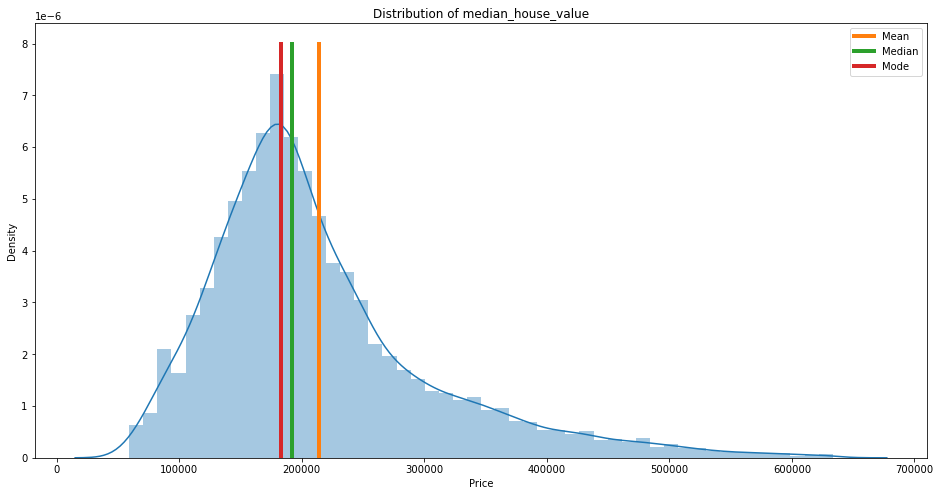

In [21]:
plt.figure(figsize = (16, 8))

sns.distplot(data['Price'], bins=50)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [22]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healtcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [23]:
data_num_feat = data.select_dtypes(include=('int8', 'int16', 'int32', 'float32'))
data_num_feat.drop('Price', axis=1, inplace=True)
data_num_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   DistrictId     10000 non-null  int16  
 2   Rooms          10000 non-null  float32
 3   Square         10000 non-null  float32
 4   LifeSquare     7887 non-null   float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int8   
 7   HouseFloor     10000 non-null  float32
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Social_1       10000 non-null  int8   
 11  Social_2       10000 non-null  int16  
 12  Social_3       10000 non-null  int16  
 13  Healthcare_1   5202 non-null   float32
 14  Healtcare_2    10000 non-null  int8   
 15  Shops_1        10000 non-null  int8   
dtypes: float32(7), int16(4), int32(1), int8(4)
memory usage: 429.8 KB


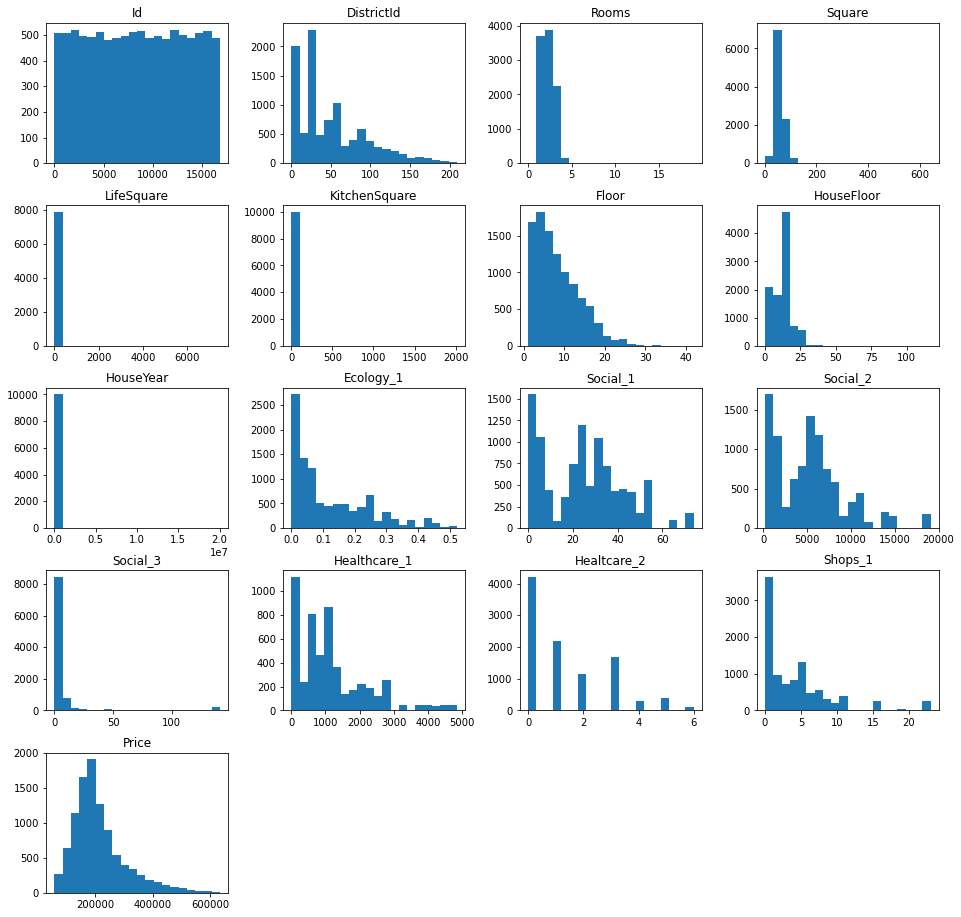

In [24]:
data.hist(figsize=(16,16), bins=20, grid=False);

## Чистим NaN

In [25]:
data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healtcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [26]:
data.loc[data['LifeSquare'].isna(), 'LifeSquare'] = data['LifeSquare'].median()
data.loc[data['Healthcare_1'].isna(), 'Healthcare_1'] = data['Healthcare_1'].median()

## Начинаем избавляться от выбросов

Количество комнат

In [27]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [28]:
data.loc[data['Rooms'] == 0, 'Rooms'] = data['Rooms'].median()

Площадь и площадь кухни

In [29]:
data.loc[data['Square'] > 300, 'Square'] = data['Square'].median()

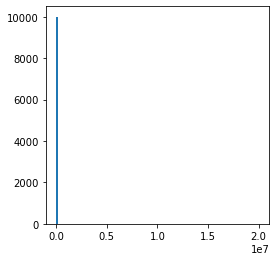

In [30]:
data['HouseYear'].hist(figsize=(4,4), bins=100, grid=False);

In [31]:
data.loc[data['LifeSquare'] > 300, 'LifeSquare'] = data['LifeSquare'].median()
data.loc[data['KitchenSquare'] > 300, 'KitchenSquare'] = data['KitchenSquare'].median()

Год основания дома

In [32]:
data.loc[(data['HouseYear'] > 2022) | (data['HouseYear'] < 1910), 'HouseYear'] = data['HouseYear'].median()

In [33]:
data['HouseYear'].value_counts()

1977    2654
2017     308
2016     305
2015     299
2014     210
        ... 
1910       1
1928       1
1947       1
1914       1
1916       1
Name: HouseYear, Length: 95, dtype: int64

Категориальные признаки

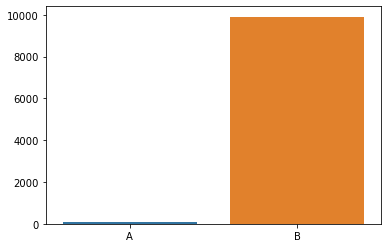

In [34]:
eco2_counts = data['Ecology_2'].value_counts()
sns.barplot(eco2_counts.index, eco2_counts.values)
plt.show()

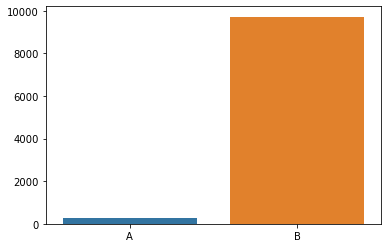

In [35]:
eco3_counts = data['Ecology_3'].value_counts()
sns.barplot(eco3_counts.index, eco3_counts.values)
plt.show()

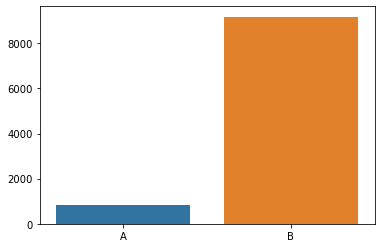

In [36]:
shops2_counts = data['Shops_2'].value_counts()
sns.barplot(shops2_counts.index, shops2_counts.values)
plt.show()

Матрицу корреляций построим, почему нет?

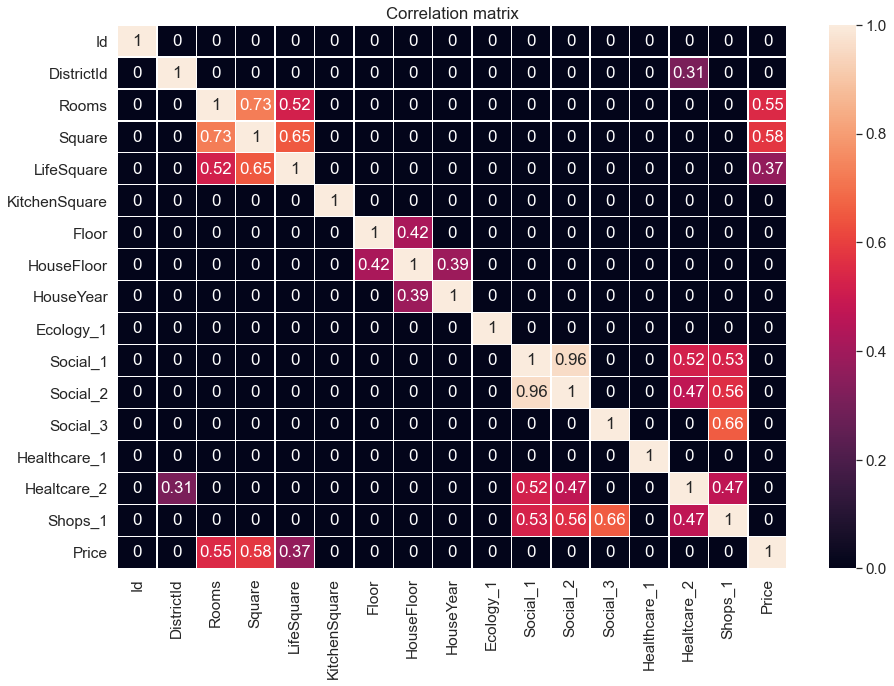

In [37]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = data.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='rocket')
plt.title('Correlation matrix')
plt.show()

Возможно, стоит убрать Social и рассмотреть объединение Rooms, Square и LifeSquare

In [39]:
data = pd.concat([data, pd.get_dummies(data['Ecology_2'])], axis=1)
data.rename({'A':'Eco_2_A', 'B':'Eco_2_B'}, axis='columns', inplace=True)
data = pd.concat([data, pd.get_dummies(data['Ecology_3'])], axis=1)
data.rename({'A':'Eco_3_A', 'B':'Eco_3_B'}, axis='columns', inplace=True)
data = pd.concat([data, pd.get_dummies(data['Shops_2'])], axis=1)
data.rename({'A':'Shops_2_A', 'B':'Shops_2_B'}, axis='columns', inplace=True)

In [40]:
data.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Id'], axis=1, inplace=True)

In [67]:
data.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Healtcare_2,Shops_1,Price,Eco_2_A,Eco_2_B,Eco_3_A,Eco_3_B,Shops_2_A,Shops_2_B
0,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,11,...,900.0,0,0,305018.875000,0,1,0,1,0,1
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,...,1183.0,1,0,177734.546875,0,1,0,1,0,1
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,...,240.0,3,1,282078.718750,0,1,0,1,0,1
3,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,1,...,900.0,0,1,168106.000000,0,1,0,1,0,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,...,900.0,0,6,343995.093750,0,1,0,1,0,1
5,99,3.0,62.528465,47.103832,6.0,9,9.0,1972,0.012339,35,...,2078.0,2,4,161044.937500,0,1,0,1,0,1
6,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,24,...,80.0,0,3,142402.734375,0,1,0,1,0,1
7,59,2.0,50.391815,32.893257,8.0,8,17.0,1986,0.019509,37,...,176.0,5,5,326174.187500,0,1,0,1,0,1
8,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,1,...,900.0,0,1,160400.406250,0,1,0,1,0,1
9,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,5,...,540.0,0,0,194756.031250,0,1,0,1,0,1


Сохраним данные?

In [68]:
with open('init_prep_data', 'wb') as f:
    pickle.dump(data, f)

Извлечём обратно

In [69]:
with open('init_prep_data', 'rb') as f:
    data = pickle.load(f)

In [70]:
X = data.drop('Price', axis=1)

In [71]:
Y = data['Price']

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [73]:
X_train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Healtcare_2', 'Shops_1', 'Eco_2_A',
       'Eco_2_B', 'Eco_3_A', 'Eco_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [78]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [79]:
X_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Healtcare_2,Shops_1,Eco_2_A,Eco_2_B,Eco_3_A,Eco_3_B,Shops_2_A,Shops_2_B
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,0.280704,-0.113429,0.146828,0.150817,-0.017536,0.178107,0.063321,0.294742,0.259037,-0.012052,...,1.181257,0.769379,0.153643,0.296821,0.010143,-0.010143,0.026857,-0.026857,0.084286,-0.084286
std,0.778375,0.815616,0.790425,0.991980,0.649514,0.650288,0.844739,0.706086,0.675432,0.585189,...,4.707430,4.653147,0.743838,1.192050,0.100207,0.100207,0.161677,0.161677,0.277836,0.277836
min,-0.616071,-1.000000,-2.137526,-2.026263,-0.750000,-0.750000,-1.500000,-2.500000,-0.408034,-0.833333,...,-0.400000,-5.625000,-0.500000,-0.750000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
25%,-0.276786,-1.000000,-0.446284,-0.472316,-0.625000,-0.375000,-0.375000,-0.115385,-0.308244,-0.633333,...,-0.400000,-0.437500,-0.500000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.723214,0.000000,0.553716,0.527684,0.375000,0.625000,0.625000,0.884615,0.691756,0.366667,...,0.600000,0.562500,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.116071,8.000000,9.306004,14.426804,13.250000,4.375000,13.125000,1.653846,2.542998,1.633333,...,27.800000,24.681250,2.500000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000


R2:	0.525
RMSE:	63043.09
MSE:	3974431147.223


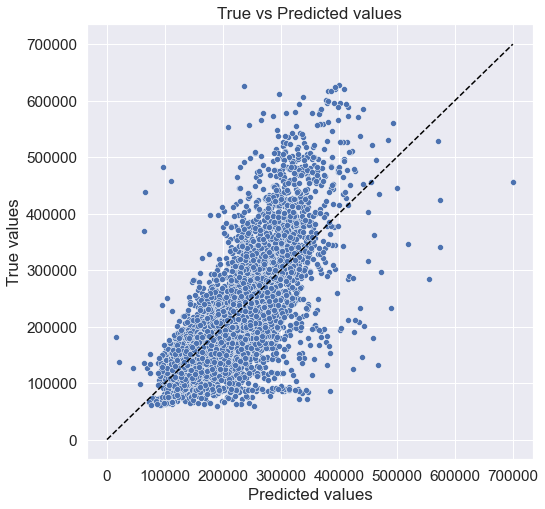

In [85]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

Y_train_pred = lr.predict(X_train)
Y_train_pred = np.clip(Y_train_pred, a_min=10000, a_max=700000)

evaluate_preds(Y_train, Y_train_pred)

R2:	0.536
RMSE:	65393.26
MSE:	4276278462.312


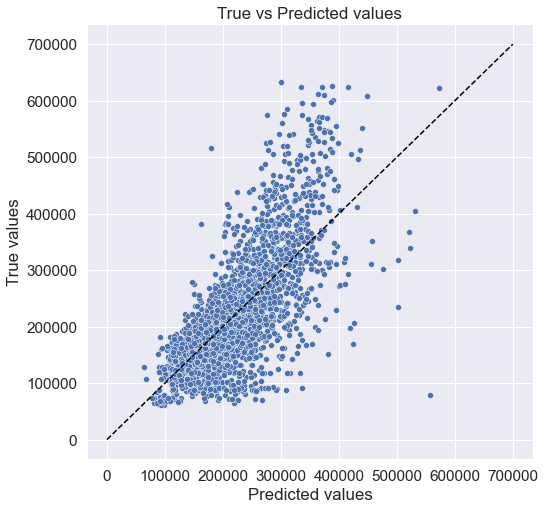

In [86]:
Y_test_pred = lr.predict(X_test)

evaluate_preds(Y_test, Y_test_pred)

R2:	0.894
RMSE:	29738.193
MSE:	884360148.001


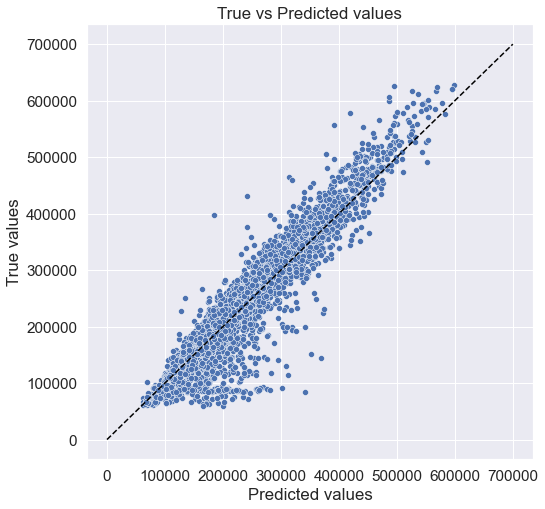

In [87]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, Y_train)

Y_train_preds = gb_model.predict(X_train)
evaluate_preds(Y_train, Y_train_preds)

R2:	0.749
RMSE:	48090.733
MSE:	2312718641.18


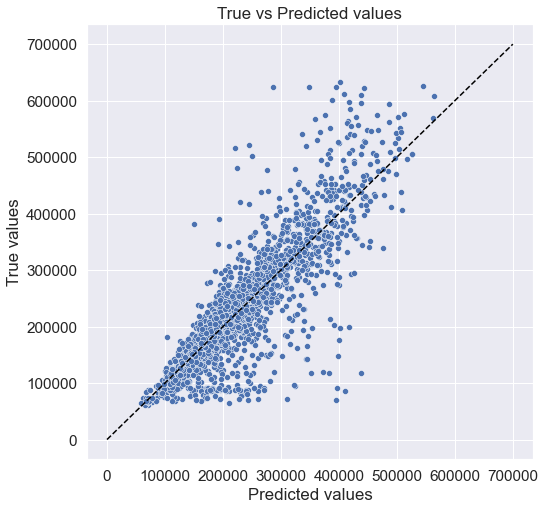

In [89]:
Y_test_preds = gb_model.predict(X_test)
evaluate_preds(Y_test, Y_test_preds)

Делаем модель линейной регрессии, просто для интереса

In [18]:
X_s = data.loc[data['LifeSquare'].notnull(), ['Square', "KitchenSquare"]]
Y_s = data.loc[data['LifeSquare'].notnull(), ['LifeSquare']]

In [19]:
Y_s = Y_s.to_numpy().flatten()

In [20]:
X_s_train, X_s_test, Y_s_train, Y_s_test = train_test_split(X_s, Y_s, test_size=0.3, random_state=42)

In [22]:
%config InlineBackend.figure_format = 'png'

R2:	0.592
RMSE:	11.571
MSE:	133.897


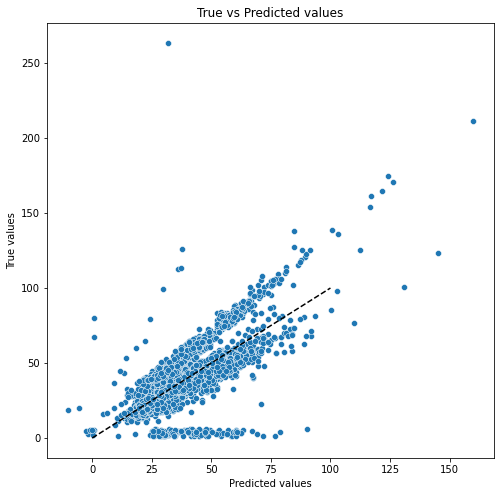

In [23]:
lr = LinearRegression()
lr.fit(X_s_train, Y_s_train)

Y_s_train_pred = lr.predict(X_s_train)

evaluate_preds(Y_s_train, Y_s_train_pred)

R2:	0.573
RMSE:	11.604
MSE:	134.656


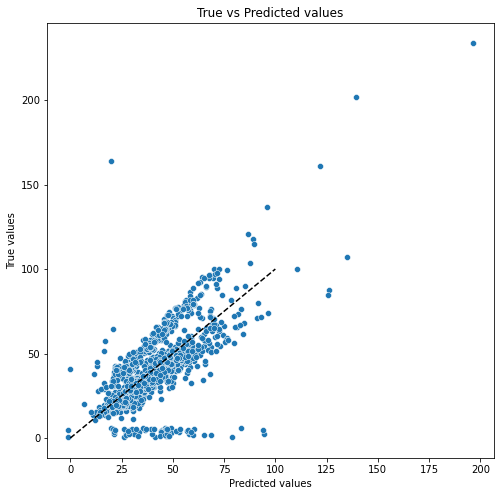

In [24]:

Y_s_test_pred = lr.predict(X_s_test)

evaluate_preds(Y_s_test, Y_s_test_pred)